In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image 
import requests
import os
from google.colab.patches import cv2_imshow
import imutils

## Create Card Dataset

In [ ]:
url = "https://api.fabdb.net/cards?per_page=30&page=2"
r = requests.get(url)
data = r.json()

In [ ]:
data.keys() 

dict_keys(['data', 'links', 'meta'])

In [ ]:
len(data['data']), len(data['links']), len(data['meta'])

(30, 4, 8)

In [ ]:
data['data']

In [ ]:
image_url = "https://fabdb2.imgix.net/cards/printings/ARC059.png?w=400&fit=clip&auto=compress,format" 
img_data = requests.get(image_url).content
with open('image_name.jpg', 'wb') as handler:
    handler.write(img_data)

In [ ]:
tot_pages = 55

for page_num in range(1,tot_pages+1):
    url = "https://api.fabdb.net/cards?per_page=30&page=" + str(page_num)
    r = requests.get(url)
    ret = r.json()
    data = ret['data']

    for card in data:
        card_name = card['name']
        card_name = card_name.strip()
        card_name = card_name.replace(" ", "_")
        card_name = card_name.replace(",", "")
        card_name = card_name.replace("'", "")
        card_name = card_name.replace(".", "")
        card_name = card_name.replace("?", "")
        card_name = card_name.replace("!", "")
        
        card_image = card['image']
        print(card_name)
        print(card_image)

        img_data = requests.get(card_image).content
        img_name = f"{card_name}.png"
        img_url = "/content/drive/MyDrive/FAB_Cards/" + img_name
        with open(img_url, 'wb') as handler:
            handler.write(img_data)
            handler.close()
    
    # print("----------------")
    # img_url = ""
    # print(f"Page Num = {page_num}")
    # print(data)
    # print(len(data['data']), len(data['links']), len(data['meta']))

## Synthetic Image Testing

Testing the Algorithm for my Synthetic Dataset


In [ ]:
# Source: https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [ ]:
cards_url       = "/content/drive/MyDrive/FAB_Cards"
backgrounds_url = "/content/drive/MyDrive/Backgrounds"

cards       = os.listdir(cards_url)
backgrounds = os.listdir(backgrounds_url)

In [ ]:
len(cards), len(backgrounds)

(882, 5640)

In [ ]:
# https://github.com/NVIDIA/retinanet-examples/issues/233

# centre = np.array([xmin + w / 2.0, ymin + h / 2.0])
# original_points = np.array([[xmin, ymin],                # This would be the box if theta = 0
#                             [xmin + w, ymin],
#                             [xmin + w, ymin + h],
#                             [xmin, ymin + h]])
# rotation = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
# corners = np.matmul(original_points - centre, rotation) + centre

# from PIL import Image, ImageDraw
    
# image = Image.open(filepath).convert("RGB")
# draw = ImageDraw.Draw(image)

# # For each annotation:
# corners.append(corners[0])                           # You need this to close the box
# draw.line(corners, fill=colour, width=width)
# image.save(output_path, quality=95)

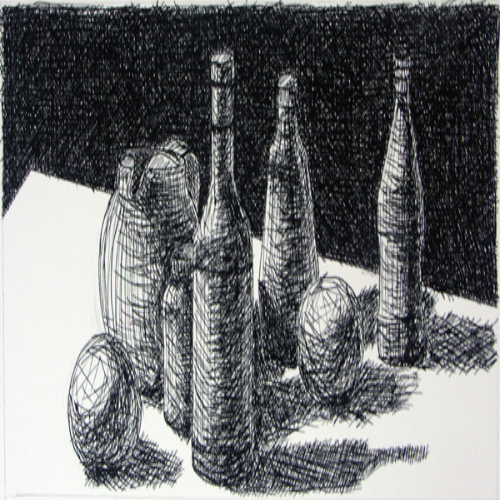

In [ ]:
bg_idx = np.random.randint(0, len(backgrounds)-1)
bg = cv2.imread(os.path.join(backgrounds_url, backgrounds[bg_idx]), cv2.IMREAD_UNCHANGED)
bg = cv2.resize(bg, (500, 500))
cv2_imshow(bg) 

(558, 400, 4)
400 558


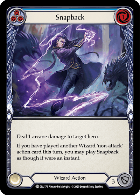

In [ ]:
scale = 0.35

card_idx = np.random.randint(0, len(cards)-1)
card = cv2.imread(os.path.join(cards_url, cards[card_idx]),cv2.IMREAD_UNCHANGED)

print(card.shape)

h, w, _ = card.shape

angle = np.random.randint(0,15)

card = cv2.resize(card, (int(w * scale), int(h * scale)))
card = rotate_image(card, angle)

print(w, h)

cv2_imshow(card)

In [ ]:
card.shape

(148, 113, 4)

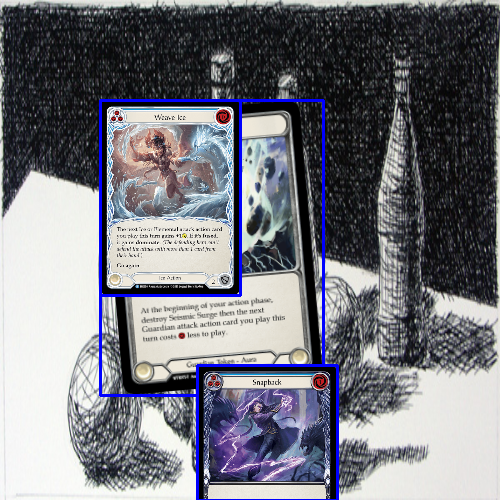

In [ ]:
# Source: https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv

x_offset = np.random.randint(0, 400)
y_offset = np.random.randint(0, 400)

c_x1, c_x2 = 0, card.shape[1]
c_y1, c_y2 = 0, card.shape[0]

y1, y2 = y_offset, y_offset + card.shape[0]
x1, x2 = x_offset, x_offset + card.shape[1]

if y2 >= bg.shape[0]:
    c_y2 -= y2 - bg.shape[0]
    y2 = bg.shape[0]

if x2 >= bg.shape[1]:
    c_x2 -= x2 - bg.shape[1]
    x2 = bg.shape[1]
    
alpha_card = card[c_y1:c_y2,c_x1:c_x2,3] / 255.0
alpha_bg = 1.0 - alpha_card

# print(f"card shape = {card_im.shape}")
# print(f"bg shape = {bg_im.shape}")

# print(f"bg pos = {x1, x2, y1, y2}")
# print(f"card pos = {c_x1, c_x2, c_y1, c_y2}")

# print(bg_im[y1:y2, x1:x2, :].shape)
# print(card_im[c_y1:c_y2, c_x1:c_x2, :].shape)

for c in range(0, 3):
    bg[y1:y2, x1:x2, c] = (alpha_card * card[c_y1:c_y2,c_x1:c_x2, c] +
                              alpha_bg * bg[y1:y2, x1:x2, c])

start_point = (x1, y1)
end_point   = (x2, y2)

bg = cv2.rectangle(bg, start_point, end_point, (255,0,0), 2)







# print(start_point, end_point)
# print(f"card shape = {card_im.shape}")
# print(f"bg shape = {bg_im.shape}")

# gray = cv2.cvtColor(bg,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# cv2_imshow(thresh)

cv2_imshow(bg)

In [ ]:
def add_card(bg, card):

        # x_offset = np.random.randint(0, int(bg.shape[1]))
        # y_offset = np.random.randint(0, int(bg.shape[0]))

        x_offset = np.random.randint(0, 400)
        y_offset = np.random.randint(0, 400)

        c_x1, c_x2 = 0, card.shape[1]
        c_y1, c_y2 = 0, card.shape[0]

        y1, y2 = y_offset, y_offset + card.shape[0]
        x1, x2 = x_offset, x_offset + card.shape[1]

        # if y1 < 0:
        #     c_y1 + 
        
        # if x1 < 0: 

        if y2 >= bg.shape[0]:
            c_y2 -= y2 - bg.shape[0]
            y2 = bg.shape[0]

        if x2 >= bg.shape[1]:
            c_x2 -= x2 - bg.shape[1]
            x2 = bg.shape[1]
           
        alpha_card = card[c_y1:c_y2,c_x1:c_x2,3] / 255.0
        alpha_bg = 1.0 - alpha_card

        for c in range(0, 3):
            bg[y1:y2, x1:x2, c] = (alpha_card * card[c_y1:c_y2,c_x1:c_x2, c] +
                                    alpha_bg * bg[y1:y2, x1:x2, c])

        start_point = (x1, y1)
        end_point   = (x2, y2)

        bg = cv2.rectangle(bg, start_point, end_point, (255,0,0), 2)

        

        # cv2_imshow(bg)

In [ ]:
def generate_sample(num_imgs, cards, backgrounds):
    
    bg_idx = np.random.randint(0, len(backgrounds)-1)
    bg = cv2.imread(os.path.join(backgrounds_url, backgrounds[bg_idx]), cv2.IMREAD_UNCHANGED)
    bg = cv2.resize(bg, (500, 500))
    
    for i in range(num_imgs):
    
        scale = np.random.uniform(0.20, 0.35)

        card_idx = np.random.randint(0, len(cards)-1)
        card = cv2.imread(os.path.join(cards_url, cards[card_idx]), cv2.IMREAD_UNCHANGED)

        h, w, _ = card.shape

        angle = np.random.randint(0,360)

        card = cv2.resize(card, (int(w * scale), int(h * scale)))
        card = rotate_image(card, angle)

        add_card(bg, card)

    cv2_imshow(bg)

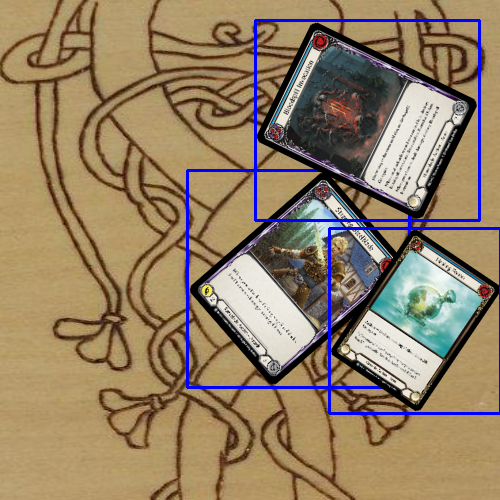

In [ ]:
generate_sample(3, cards, backgrounds)